# Stargazing Suitability Data Pipeline

## 1. Introduction

This project presents a real-time data pipeline that computes stargazing suitability scores for a user's entered location and nearby major cities using live weather and environmental data. It leverages modern data engineering tools—**Kafka, Apache Spark, and Docker**—to demonstrate a complete ingestion-to-insight workflow.


## 2. Problem Statement

Urban light pollution and dynamic weather conditions make stargazing unpredictable. This project addresses the problem by designing a data pipeline that continuously fetches relevant weather metrics and computes a real-time **stargazing score**, helping users decide when and where the sky will be most clear and suitable for viewing.


## 3. Description of Dataset and Data Product

**APIs Used:**
- OpenWeatherMap OneCall API (clouds, humidity, visibility)
- OpenWeatherMap Air Pollution API (PM2.5)
- Moon Illumination (calculated using lunar cycle)

**Data Fields:**
- `city`, `timestamp`, `clouds`, `humidity`, `visibility`, `pm25`, `moon_illumination`
- Computed `score` (0-1) and a text `summary`

**Output:**
- Real-time Kafka stream of JSON records
- Console display using Spark Structured Streaming
- Optional file sink for archival



## 4. Data Pipeline Architecture

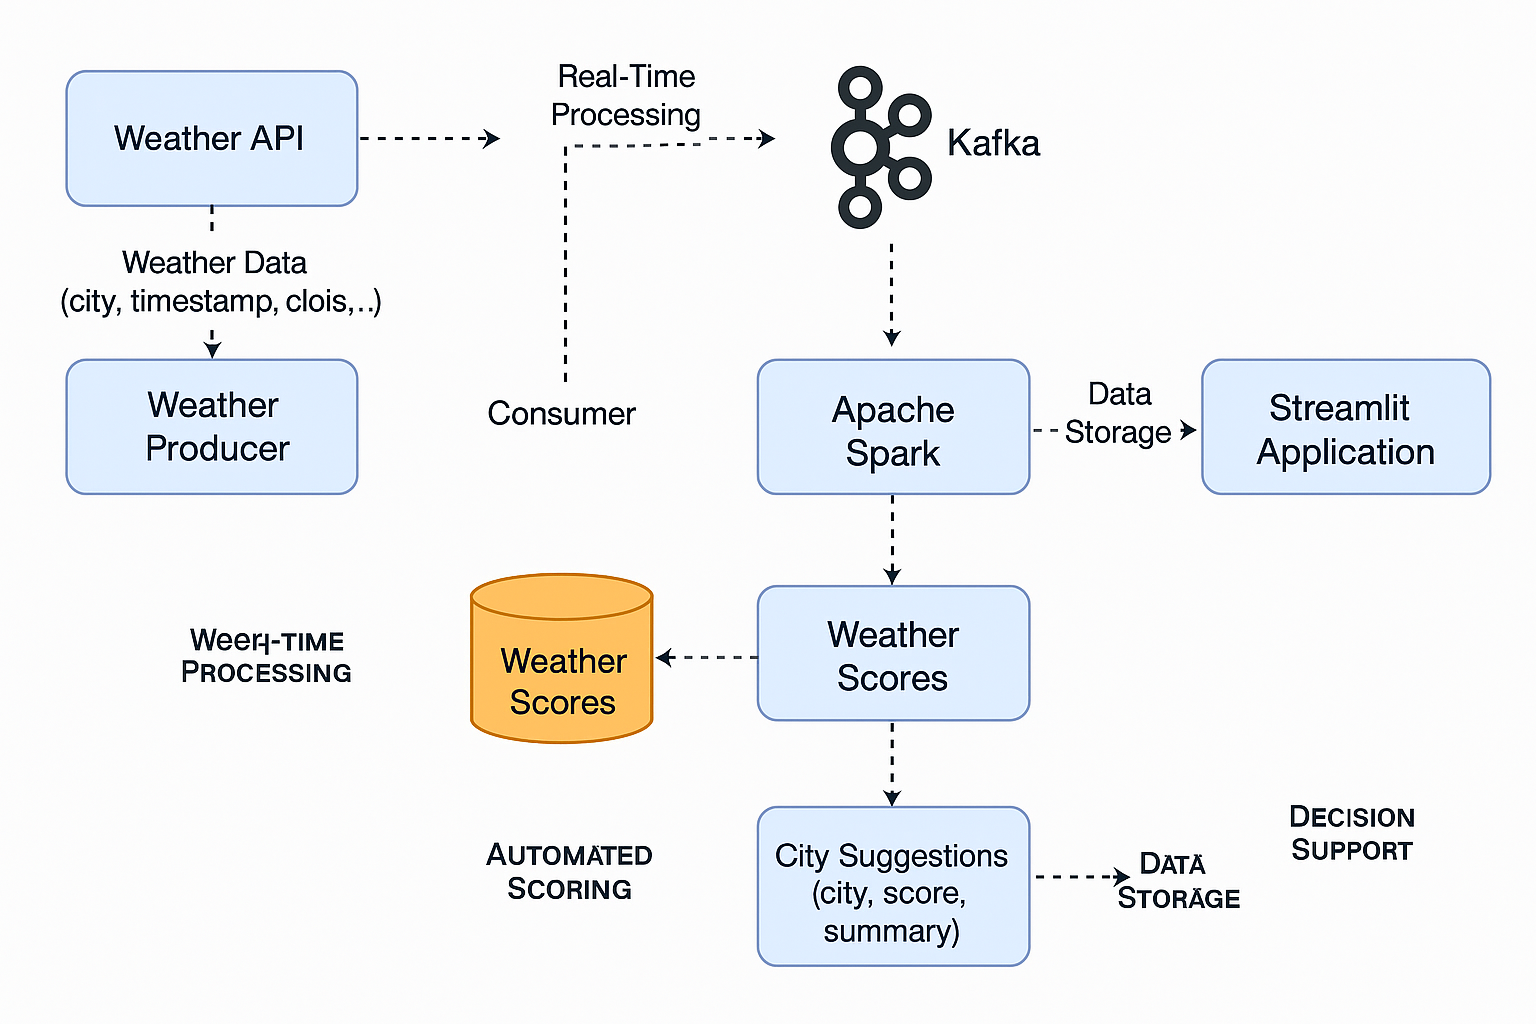

1. **Kafka Producer** simulates real-time ingestion using weather APIs.
2. **Apache Spark Structured Streaming** consumes and parses the stream.
3. **Scoring Logic** computes a normalized `stargazing_score`.
4. **Output Sink** logs output to console or stores it in disk as JSON.

```
[API Fetcher] --> [Kafka Topic: weather] --> [Spark Consumer] --> [Parsed Data + Score] --> [Console/Storage]
```


## 5. Kafka Producer

In [ ]:
from kafka import KafkaProducer
import json, time, requests

producer = KafkaProducer(bootstrap_servers='localhost:9092',
                         value_serializer=lambda v: json.dumps(v).encode('utf-8'))

def get_weather():
    # Simulate weather data
    return {
        "city": "Lahore",
        "timestamp": int(time.time()),
        "clouds": 20,
        "humidity": 60,
        "visibility": 10000,
        "pm25": 25,
        "moon_illumination": 0.6,
        "score": round((1 - 0.2) * (1 - 0.6) * (10000 / 10000) * (1 - 0.25), 3),
        "summary": "partly cloudy"
    }

while True:
    weather = get_weather()
    producer.send("weather", weather)
    print("Sent:", weather)
    time.sleep(10)


## 6. Spark Structured Streaming Consumer

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StringType, IntegerType, DoubleType

spark = SparkSession.builder     .appName("WeatherKafkaConsumer")     .master("local[*]")     .getOrCreate()

schema = StructType()     .add("city", StringType())     .add("timestamp", IntegerType())     .add("clouds", IntegerType())     .add("humidity", IntegerType())     .add("visibility", IntegerType())     .add("pm25", DoubleType())     .add("moon_illumination", DoubleType())     .add("score", DoubleType())     .add("summary", StringType())

df = spark.readStream     .format("kafka")     .option("kafka.bootstrap.servers", "localhost:9092")     .option("subscribe", "weather")     .load()

json_df = df.selectExpr("CAST(value AS STRING)")     .select(from_json(col("value"), schema).alias("data"))     .select("data.*")

query = json_df.writeStream     .format("console")     .outputMode("append")     .start()

query.awaitTermination()


## 7. Screenshots / Visuals


**Starting Kafka Instance via Docker in PowerShell:**

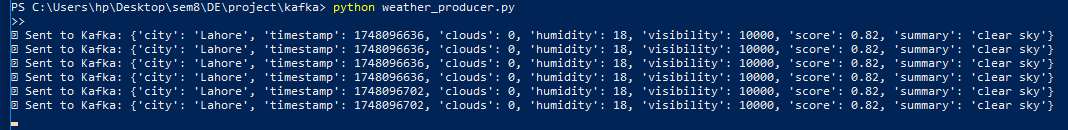

**Streaming Kafka Consumer Messages:**

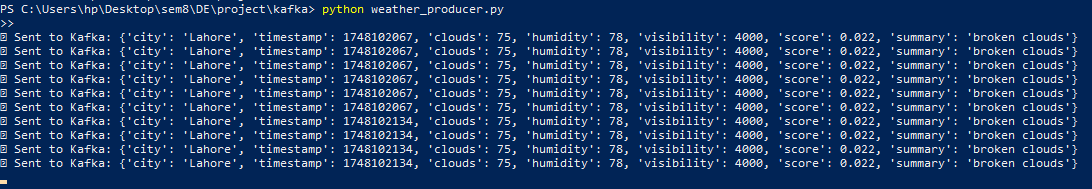

**Created Topic 'Weather' in Kafka:**

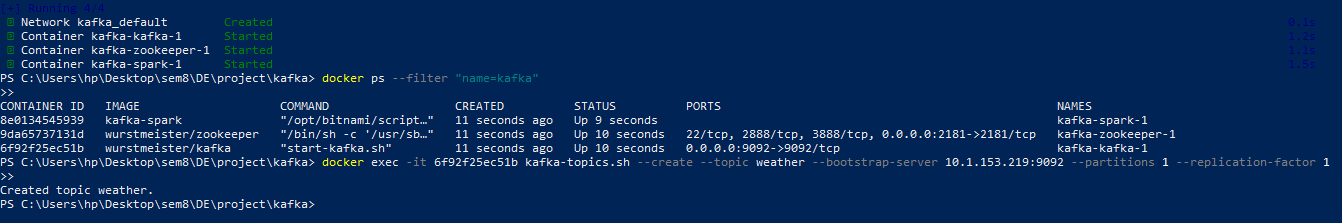